In [1]:
from google.colab import drive
drive.mount("/content/gdrive")
%cd '/content/gdrive/MyDrive/LDS6_S7N_TranHoangBach/LDS6_TranHoangBach_CuoiKy'

Mounted at /content/gdrive
/content/gdrive/MyDrive/LDS6_S7N_TranHoangBach/LDS6_TranHoangBach_CuoiKy


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

In [3]:
from sklearn.datasets import load_files
 
DATA_DIR = "./bbc/"
data = load_files(DATA_DIR, encoding="utf-8", decode_error="replace")

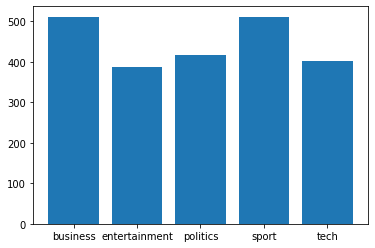

In [4]:
# Xem thử text data phân loại thành các tệp ra sao
labels, counts = np.unique(data.target, return_counts=True)
labels_str = np.array(data.target_names)[labels]
plt.bar(labels, counts)
plt.xticks(labels, labels_str)
plt.show()

In [5]:
df = pd.DataFrame({'content': data.data, 'class': labels_str[data.target]})
df.head()

,content,class
0,Tate & Lyle boss bags top award\n\nTate & Lyle...,business
1,Halo 2 sells five million copies\n\nMicrosoft ...,tech
2,MSPs hear renewed climate warning\n\nClimate c...,politics
3,Pavey focuses on indoor success\n\nJo Pavey wi...,sport
4,Tories reject rethink on axed MP\n\nSacked MP ...,politics


In [6]:
df['content'][3]

'Pavey focuses on indoor success\n\nJo Pavey will miss January\'s View From Great Edinburgh International Cross Country to focus on preparing for the European Indoor Championships in March.\n\nThe 31-year-old was third behind Hayley Yelling and Justyna Bak in last week\'s European Cross Country Championships but she prefers to race on the track. "It was great winning bronze but I\'m wary of injuries and must concentrate on the indoor season," she said. "Because of previous injuries I don\'t even run up hills in training." Pavey, who came fifth in the 5,000m at the Athens Olympics, helped the British cross country team win the team silver medal in Heringsdorf last week. She is likely to start her 3,000m season with a race in either Boston or Stuttgart at the end of January.\n'

Phân tích đề bài:
- Đề bài thuộc Text Unsupervised Learning, phân cụm các content thành 5 nhóm, sau đó so sánh với class original xem có sự phân cụm có trùng với class label ban đầu hay không.
- Mỗi text để có các ký tự đặc biệt, ('\n  " ?), nên pre-processing trước khi thực hiện các bước khác. 
- Trước khi phân cụm cần Vectorizer text data thành các Vector, có thể sử dụng Count Vectorizer hay TF-IDF. Trong bài toán này ta sử dụng TF-IDF vì TF-IDF thường hiệu quả hơn thuật toán Count đơn giản.
- Vì khi Vectorizer trong NLP sẽ có Vocalulary rất lớn, từ đó dimension của vector sau khi converted sẽ rất lớn, nên ở đây giới hạn lại 1000 dimension cho vectorizer.
- Có 3 thuật toán phân cụm thông thường hay sử dụng trong Machine Learning là: KMeans, Hierarchical Clustering và Gaussian Mixture Models.
    - KMeans và Hierarchical phân cụm bằng việc đo khoảng cách, GMM dựa trên phân phối xác xuất.
    - Đối với bài toán này cả 3 thuật toán đều có thể sử dụng được, đồng thời không phải là bài toán đúng - sai nên kết quả không dùng để so sánh với nhau, mặc dù bài toán có labels trước đó.
    - Thông thường trong các bài toán về NLP, sparse-matrix (ví dụ như spam-ham) áp dụng Gaussian được cho là khá phù hợp "tự nhiên", vậy nên trong bài này, sẽ sử dụng GMM để phân cụm dữ liệu.

Các bước dự tính thực hiện:
- Preprocessing text data
- Vectorizer X bằng TF-IDF, max_features = 1000
- Thực hiện tính toán GMM model với k từ 2-8, tính toán chỉ số silhouette để xem số cụm phân thành bao nhiêu là phù hợp, số cụm tốt nhất có là 5, tương đồng với số labels ban đầu hay không.
- Thực hiện phân cụm với số cụm tìm được.
- Tính Cross-table để kiểm chứng lại các cụm phân loại với Class đã có.
- Vẽ WordClouds với từng cụm tìm được

In [7]:
import re
df['content'] = df['content'].apply(lambda x: x.lower())
df['content'] = df['content'].apply(lambda x: re.sub('[^A-Za-z0-9]+', ' ', x))
df['content'][3]

'pavey focuses on indoor success jo pavey will miss january s view from great edinburgh international cross country to focus on preparing for the european indoor championships in march the 31 year old was third behind hayley yelling and justyna bak in last week s european cross country championships but she prefers to race on the track it was great winning bronze but i m wary of injuries and must concentrate on the indoor season she said because of previous injuries i don t even run up hills in training pavey who came fifth in the 5 000m at the athens olympics helped the british cross country team win the team silver medal in heringsdorf last week she is likely to start her 3 000m season with a race in either boston or stuttgart at the end of january '

In [8]:
X = df['content']
y = df['class']

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words="english", max_features=1000, decode_error="ignore")
X_vector = vectorizer.fit_transform(X)
X_vector

<2225x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 149811 stored elements in Compressed Sparse Row format>

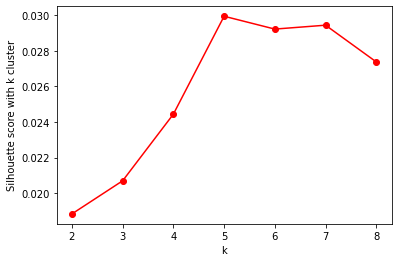

In [10]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
k_range = np.arange(2,9)
score = []
for k in k_range:
    cluster = GaussianMixture(n_components=k, random_state=0)
    y_pred = cluster.fit_predict(X_vector.toarray())
    sil = silhouette_score(X_vector.toarray(), y_pred)
    score.append(sil)

plt.plot(k_range, score, 'ro-')
plt.xlabel('k')
plt.ylabel('Silhouette score with k cluster')
plt.show()

Số cụm tốt nhất mà GMM đề xuất là 5 vì có Silhouette lớn nhất, cũng tương đồng với số lượng 5 labels ban đầu.

In [11]:
# Thực hiện phân cụm với k = 5
gmm = GaussianMixture(n_components=5, random_state=42)
y_pred = gmm.fit_predict(X_vector.toarray())
df['cluster'] = y_pred
df.head(10)

,content,class,cluster
0,tate lyle boss bags top award tate lyle s chie...,business,4
1,halo 2 sells five million copies microsoft is ...,tech,1
2,msps hear renewed climate warning climate chan...,politics,4
3,pavey focuses on indoor success jo pavey will ...,sport,0
4,tories reject rethink on axed mp sacked mp how...,politics,3
5,lib dems predict best ever poll the lib dems a...,politics,3
6,howard attacks pay later budget tory leader mi...,politics,3
7,games win for blu ray dvd format the next gene...,tech,1
8,labour pig poster anti semitic the labour part...,politics,3
9,costin aims for comeback in 2006 jamie costin ...,sport,0


In [12]:
cross_table = pd.crosstab(index=y, columns=y_pred, rownames=['Original Category'], colnames=['Clustering'])
cross_table

Clustering,0,1,2,3,4
Original Category,,,,,
business,1,13,1,11,484
entertainment,10,48,298,5,25
politics,2,18,0,364,33
sport,508,0,2,0,1
tech,16,372,6,0,7


In [13]:
same = cross_table.loc['sport',0] + cross_table.loc['tech',1] + cross_table.loc['entertainment',2] + cross_table.loc['politics',3] + cross_table.loc['business',4]
total = cross_table.sum().sum()
percent = same/total
print('Mức độ tương đồng Clustering với Category ban đầu {:.2f}%'.format(percent*100))

Mức độ tương đồng Clustering với Category ban đầu 91.06%


Nhận xét:
- Kết quả Clustering có nhiều tương đồng với Category đã phân loại từ ban đầu (91.06%).
- Vậy nên đặt tên các cụm [0, 1, 2, 3, 4] theo thứ tự sẽ là ['sport', 'tech', 'entertainment', 'politics', 'business']

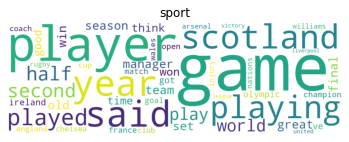

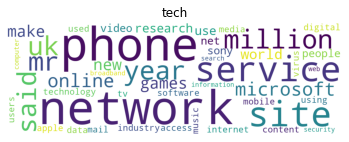

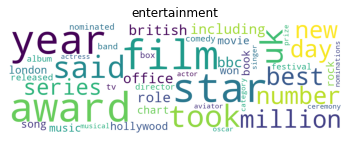

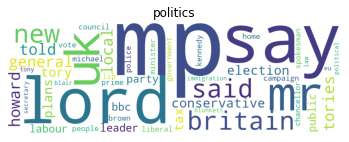

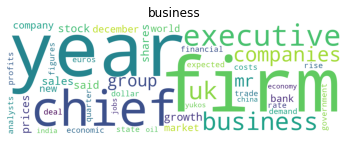

In [14]:
# Viết function để tìm các keywords bằng các coefficient lớn nhất (lấy từ means của các cụm), rồi từ các keywords tìm được, vẽ Wordclouds
cluster_name = ['sport', 'tech', 'entertainment', 'politics', 'business']
n_keywords = 50
list_keywords = []

for i in range(5):
    index = gmm.means_[i].argsort()[-n_keywords:]
    keywords = []
    vocab = vectorizer.vocabulary_
    for word, idx in vocab.items():
        if idx in index:
            keywords.append(word)
    list_keywords.append(keywords)

from wordcloud import WordCloud
for keywords, name in zip(list_keywords, cluster_name):
    wordcloud = WordCloud(background_color = 'white', width = 1200, height = 400).generate(' '.join(keywords))
    plt.imshow(wordcloud)
    plt.title(name)
    plt.axis('off')
    plt.grid(False)
    plt.show()

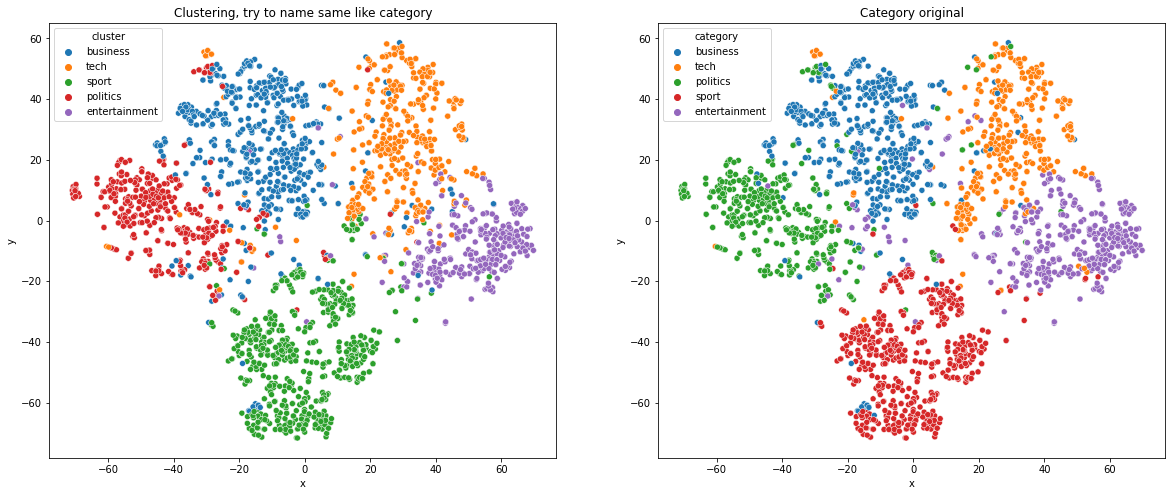

In [31]:
# Thử trực quan hoá việc phân cụm, sử dụng manifold trải lên không gian 2 chiều
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_vector)
df_tsne = pd.DataFrame(X_tsne, columns=['x', 'y'])
df_tsne['category'] = y
# df_tsne['cluster'] = y_pred
df_tsne['cluster'] = np.array(cluster_name)[y_pred.tolist()]

plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
sb.scatterplot(data=df_tsne, x='x', y='y', hue='cluster', cmap='colorblind')
plt.title('Clustering, try to name same like category')

plt.subplot(1,2,2)
sb.scatterplot(data=df_tsne, x='x', y='y', hue='category', cmap='colorblind')
plt.title('Category original')
plt.show()

Thông qua việc trực quan hoá, một lần nữa có thể thấy được các đặc tính để Clustering là tương đồng với Category ban đầu của từng tệp data.